# Prepare Datasets

There are three datasets
<ul>
 <li>the enron email connectivity graph</li>
 <li>the Karate Club network</li>
 <li>the Les Miserable co-occurrence graph</li>
</ul>

In order to work with these data files we make sure that they are all in the same format. The enron email connectivity graph is provided as an edgelist, while both the Karate club network and Les Miserable co-occurrence graph are stored as GML files.

## Load Datasets

<ol>
 <li>Read the enron email connectivity Graph</li>
</ol>

In [1]:
import numpy as np
dataEnron = np.genfromtxt('data/email-Enron.txt', dtype=[('from', np.int32), ('to', np.int32)])

In [2]:
dataEnron

array([(    0,     1), (    1,     0), (    1,     2), ..., (36689, 36690),
       (36690, 36689), (36691,  8203)],
      dtype=[('from', '<i4'), ('to', '<i4')])

In [3]:
import scipy.sparse as sps
matrixEnron = sps.csr_matrix((np.ones(len(dataEnron)), (dataEnron['from'], dataEnron['to'])))

<ol start=2>
 <li>Read the Les Miserables co-occurrence graph</li>
</ol>

In [6]:
import networkx as nx
graphLM = nx.read_gml('data/lesmis.gml')
matrixLM = nx.to_scipy_sparse_matrix(graphLM)

Layout a graph using the spring force algorithm.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

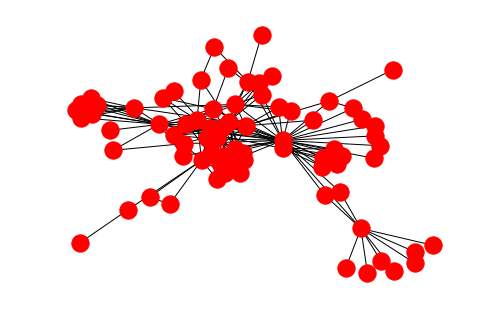

In [8]:
nx.draw_spring(graphLM)

Print the matrix.

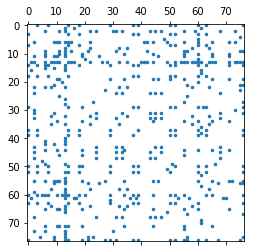

In [9]:
matrixLM = nx.to_scipy_sparse_matrix(graphLM)
plt.spy(matrixLM, precision=1e-3, marker='.', markersize=5)

Re-order the matrix in band-matrix form with minimum bandwidth using the reverse Cuthill-McKee algorithm.

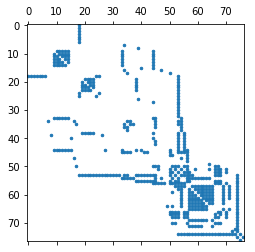

In [10]:
from networkx.utils import reverse_cuthill_mckee_ordering
rcm = list(reverse_cuthill_mckee_ordering(graphLM))
matrixLM = nx.to_scipy_sparse_matrix(graphLM, nodelist=rcm)
plt.spy(matrixLM.todense(), precision=1e-3, marker='.', markersize=5)

<ol start=3>
 <li>Read the Karate club network</li>
</ol>

In [19]:
# nx.read_gml?
graphKarate = nx.read_gml('data/karate.gml', label='id')
graphKarate

In [17]:
matrixKarate = nx.to_scipy_sparse_matrix(graphKarate)
matrixKarate

<34x34 sparse matrix of type '<type 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

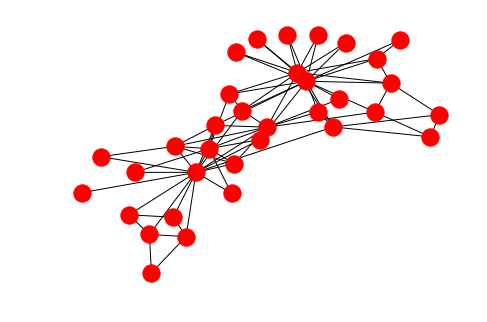

In [18]:
nx.draw_spring(graphKarate)

# Fundamental Network Statistics

## Degree

The degree is computed by $k_i=\sum_{j} A_{ij}$. The csr_matrix object in scipy defines a function sum() that takes an axis argument: axis=0 for row-sums, axis=1 for column-sums.

In [23]:
degreeKarate = matrixKarate.sum(0)
degreeLM = matrixLM.sum(0)
degreeEnron = matrixEnron.sum(0)
degreeKarate

matrix([[16,  9, 10,  6,  3,  4,  4,  4,  5,  2,  3,  1,  2,  5,  2,  2,  2,
          2,  2,  3,  2,  2,  2,  5,  3,  3,  2,  4,  3,  4,  4,  6, 12, 17]])

### Plotting

In [30]:
np.squeeze(np.asarray(degreeLM))

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  7,  7,  7,  7,  7,  7,  2,  2,
        2, 10,  6,  6,  6,  6,  6,  3,  3,  2,  2,  1,  1,  1,  1,  1,  9,
        7,  7,  4,  2,  8,  4,  4,  3,  3,  2, 15, 11,  3,  3,  1,  1, 11,
       11, 10, 36, 19, 17, 16, 15, 13, 13, 12, 12, 11, 11, 11, 10, 10, 10,
        9,  9,  7,  7,  2,  2, 22,  2,  1])

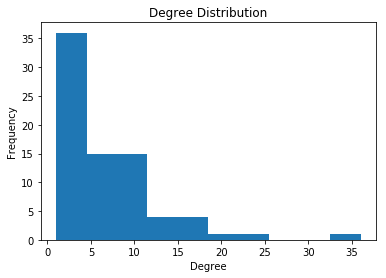

In [24]:
plt.hist(np.squeeze(np.asarray(degreeLM)))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

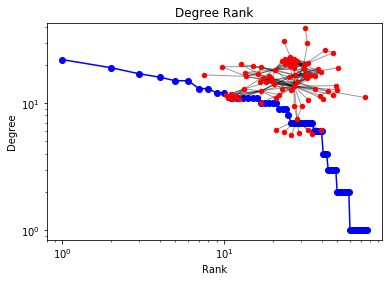

In [41]:
plt.loglog(sorted(np.squeeze(np.asarray(degreeLM)), reverse=True), 'b-', marker='o')
plt.title("Degree Rank")
plt.ylabel("Degree")
plt.xlabel("Rank")

plt.axes([0.45,0.45,0.45,0.45])
Gcc=max(nx.connected_component_subgraphs(graphLM), key=len)
pos=nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)

#### Log Binning

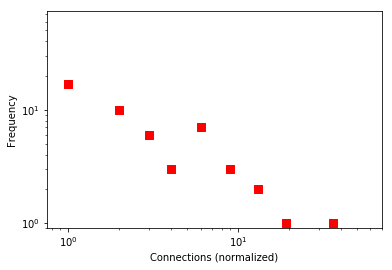

In [42]:
import collections as c

# Based on: http://stackoverflow.com/questions/16489655/plotting-log-binned-network-degree-distributions
def drop_zeros(a_list):
    return [i for i in a_list if i>0]

degreeLM_dict = dict(c.Counter(np.squeeze(np.asarray(degreeLM))))
max_x = np.log10(max(degreeLM_dict.keys()))
max_y = np.log10(max(degreeLM_dict.values()))
max_base = max([max_x,max_y])

min_x = np.log10(min(drop_zeros(degreeLM_dict.keys())))
bins = np.logspace(min_x, max_base, num=10)

bin_means_y = (np.histogram(degreeLM_dict.keys(), bins, weights=degreeLM_dict.values())[0] / np.histogram(degreeLM_dict.keys(),bins)[0])
bin_means_x = (np.histogram(degreeLM_dict.keys(), bins, weights=degreeLM_dict.keys())[0] / np.histogram(degreeLM_dict.keys(),bins)[0])

plt.xscale('log')
plt.yscale('log')
plt.scatter(bin_means_x, bin_means_y, c='r', marker='s', s=50)
plt.xlim((0.75,70))
plt.ylim((.9,75))
plt.xlabel('Connections (normalized)')
plt.ylabel('Frequency')

#### Cumulative Degree Distribution

The cumulative degree distribution can simply be computed by:
<ol>
 <li>sorting the degrees of each vertex in descending order</li>
 <li>compute the corresponding ranks $1...n$</li>
 <li>plot the rank divided by the number of vertices as a function or the degree</li>
</ol>

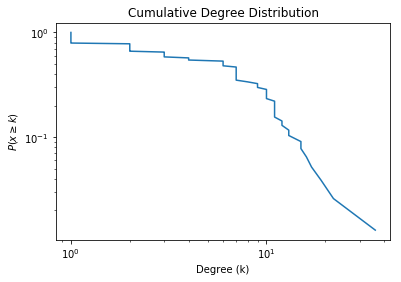

In [43]:
cumDegreeLM = np.array([np.sort(np.squeeze(np.asarray(degreeLM)))[::-1]])
cumDegreeLM = np.concatenate((cumDegreeLM, np.array([range(1, degreeLM.shape[1]+1)], dtype=np.float)), 0)
cumDegreeLM = np.concatenate((cumDegreeLM, np.array([cumDegreeLM[1]/degreeLM.shape[1]])), 0)

plt.loglog(cumDegreeLM[0,:], cumDegreeLM[2,:])
plt.title("Cumulative Degree Distribution")
plt.xlabel("Degree (k)")
plt.ylabel("$P(x \geq k)$")

### Minimum/Maximum Degrees

<ol>
 <li>Enron</li>
</ol>

In [44]:
[np.min(degreeEnron), np.max(degreeEnron)]

[1.0, 1383.0]

<ol start=2>
 <li>Karate</li>
</ol>

In [45]:
[np.min(degreeKarate), np.max(degreeKarate)]

[1, 17]

<ol start=3>
 <li>Les Miserables</li>
</ol>

In [46]:
[np.min(degreeLM), np.max(degreeLM)]

[1, 36]

## Number of Edges

The number of edges for undirected graphs are computed by: $m=\frac{1}{2}\sum_i k_i$

<ol>
 <li>Enron</li>
</ol>

In [47]:
edgesEnron = matrixEnron.sum()/2
edgesEnron

183831.0

<ol start=2>
 <li>Karate</li>
</ol>

In [48]:
edgesKarate = matrixKarate.sum()/2
edgesKarate

78

<ol start=3>
 <li>Les Miserables</li>
</ol>

In [49]:
edgesLM = matrixLM.sum()/2
edgesLM

254

## Mean Degree

The mean degree for undirected graphs is computed by: $c=\frac{2m}{n}$

<ol>
 <li>Enron</li>
</ol>

In [50]:
cEnron = 2 * edgesEnron/matrixEnron.shape[0]
cEnron

10.020222391802028

<ol start=2>
 <li>Karate</li>
</ol>

In [51]:
cKarate = 2 * edgesKarate/matrixKarate.shape[0]
cKarate

4

<ol start=3>
 <li>Les Miserables</li>
</ol>

In [52]:
cLM = 2 * edgesLM/matrixLM.shape[0]
cLM

6

## Density

The density, $\rho$, of a graph is the fraction of edges present by the maximum number of edges in a simple graph, i.e., with no multi-edges or self-edges:

$\rho=\frac{c}{n-1}$

<ol>
 <li>Enron</li>
</ol>

In [53]:
rhoEnron = cEnron/(matrixEnron.shape[0]-1.0)
rhoEnron

0.00027309755503535001

<ol start=2> 
 <li>Karate</li>
</ol>

In [54]:
rhoKarate = cKarate/(matrixKarate.shape[0]-1.0)
rhoKarate

0.12121212121212122

<ol start=3>
 <li>Les Miserables</li>
</ol>

In [55]:
rhoLM = cLM/(matrixLM.shape[0]-1.0)
rhoLM

0.078947368421052627

# NetworkX

## Degree

In [56]:
graphEnron = nx.from_edgelist(dataEnron)

In [65]:
# graphEnron.degree()
# DegreeView({0: 1, 1: 70, 2: 1, 3: 5,...

In [70]:
degree_values = [value for node, value in graphEnron.degree()]

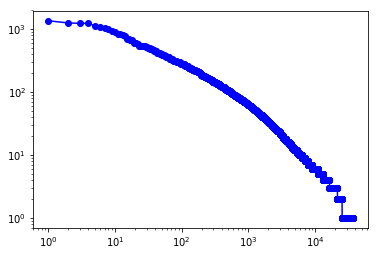

In [74]:
plt.loglog(sorted(degree_values, reverse=True), 'b-', marker='o')

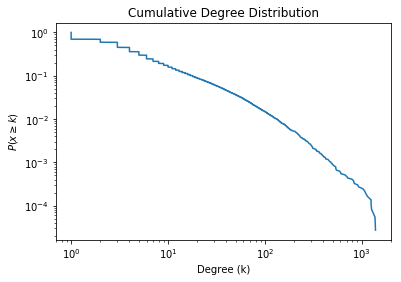

In [75]:
cumDegreeEnron = np.array([sorted(degree_values, reverse=True)])
cumDegreeEnron = np.concatenate((cumDegreeEnron, np.array([range(1, graphEnron.number_of_nodes()+1)], dtype=np.float)), 0)
cumDegreeEnron = np.concatenate((cumDegreeEnron, np.array([cumDegreeEnron[1]/graphEnron.number_of_nodes()])), 0)

plt.loglog(cumDegreeEnron[0,:], cumDegreeEnron[2,:])
plt.title("Cumulative Degree Distribution")
plt.xlabel("Degree (k)")
plt.ylabel("$P(x \geq k)$")

In [76]:
nx.density(graphEnron)

0.00027309755503535

In [77]:
nx.info(graphEnron)

'Name: \nType: Graph\nNumber of nodes: 36692\nNumber of edges: 183831\nAverage degree:  10.0202'